# 23222019 - Balansiranje

In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline

# Ležajno mesto A

## Začento stanje

### Uvoz podatkov

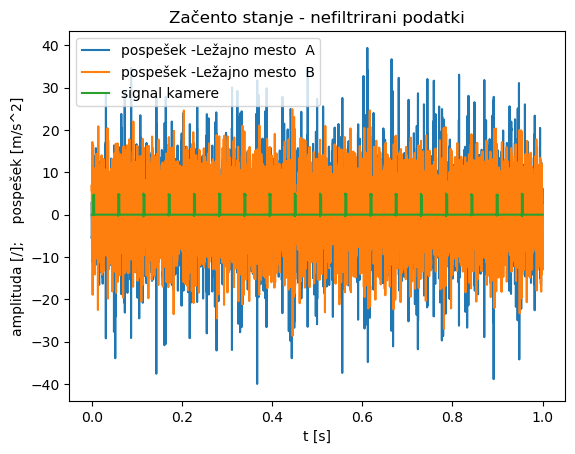

In [2]:
file0 = np.load("LV balansiranje -zacetno_stanje.npy",allow_pickle=True, fix_imports=True)
file0 = file0[()]["data"]

a0 = file0[:,0]
b0 = file0[:,1]
n0 = file0[:,2]

f_vz = 25600
t, dt = np.linspace(0,1,25600, retstep = True)
plt.plot(t,a0, label = "pospešek -Ležajno mesto  A")
plt.plot(t,b0, label = "pospešek -Ležajno mesto  B")
plt.plot(t,n0, label = "signal kamere")
plt.title("Začento stanje - nefiltrirani podatki")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/];    pospešek [m/s^2]")
plt.legend()
plt.show()

### Filtriranje signala kamere/sonde

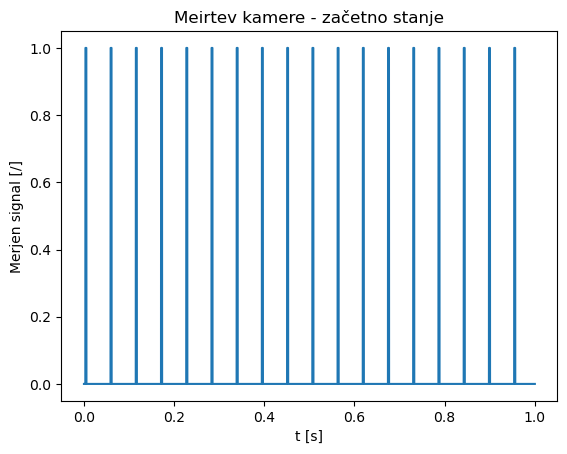

In [3]:
#filtriramo signal kamere
n0_filt = np.array([])
for i in n0:
    if i > 3:
        n0_filt = np.append(n0_filt, 1)
    else:
        n0_filt = np.append(n0_filt, 0)

plt.plot(t, n0_filt)
plt.title("Meirtev kamere - začetno stanje")
plt.xlabel("t [s]")
plt.ylabel("Merjen signal [/]")
plt.show()

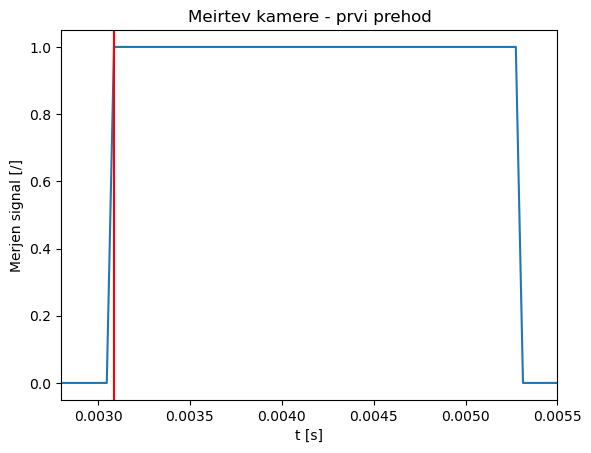

In [4]:
#odvajamo, da dobimo točke kjer se zgodi sprememba
odvod_0 = np.gradient(n0_filt, dt)

#Shranimo čase, kjer kamera zabeleži referenčno točko
indeks_vrhov_0 =sp.signal.find_peaks(odvod_0)[0]
t_vrh_0 = []
for i in range(0,len(indeks_vrhov_0)):
    t_vrh_0.append(t[indeks_vrhov_0[i]+1]) #pri i-tem indeksu je vrednost reelksivnosti še 0
    
#izris

plt.plot(t,n0_filt, "-")
plt.axvline(t_vrh_0[0], color='r')
plt.title("Meirtev kamere - prvi prehod")
plt.xlabel("t [s]")
plt.ylabel("Merjen signal [/]")
plt.xlim(0.0028,0.0055)
plt.show()

In [5]:
#izračun povprečne periode in vrtilne frekvence
counter = 0
for i in range(0,(len(t_vrh_0)-1)):
    counter += t_vrh_0[i+1] - t_vrh_0[i]
τ = counter/(len(t_vrh_0)-1)
f = 1/τ
ω = f * 2*np.pi
print(f'Povprečna perioda: τ = {τ*1000:0.2f} ms')
print(f'Ocenjena frekvenca vrtneja znaša: f = {f:0.2f} Hz = {f*60:0.2f} obr/min')
print(f'Ocenjena kotna hitrost znaša: ω = {ω:0.2f} rad/s')

Povprečna perioda: τ = 55.94 ms
Ocenjena frekvenca vrtneja znaša: f = 17.88 Hz = 1072.54 obr/min
Ocenjena kotna hitrost znaša: ω = 112.32 rad/s


### filtriranje pospeška

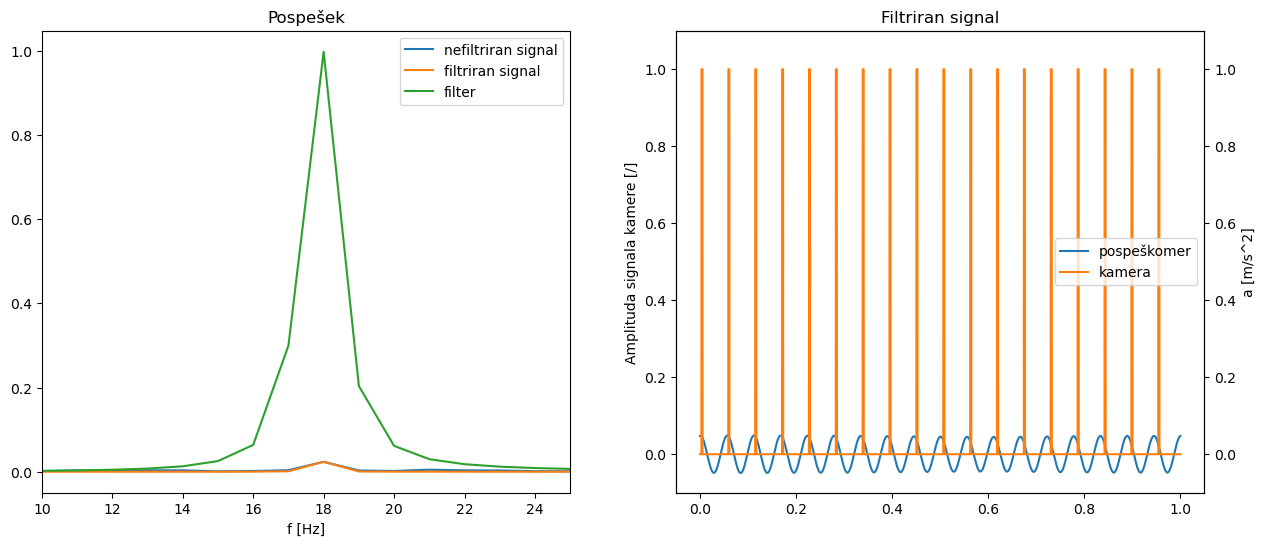

In [6]:
#FILTRIRANJE

#ustvarimo pasovni filter
freq_band_a = np.array([f-0.5, f+0.5])
b, a = signal.butter(2, freq_band_a, btype='band', fs = f_vz)

#prehod v frekvenčno domeno
A0 = np.fft.rfft(a0)/len(a0)
freq = np.fft.rfftfreq(len(t), dt)
w, H = signal.freqz(b, a, len(freq), fs=f_vz)

#Aplicirnaje filtra(množenje v frekvenčni domeni)
A0_filt = A0 * H

#vrnitev v časovno domeno
a0_filt = np.fft.irfft(A0_filt) * len(a0)


#izris
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(freq, np.abs(A0), label = "nefiltriran signal")
ax[0].plot(freq, np.abs(A0_filt), label = "filtriran signal")
ax[0].plot(freq, np.abs(H), label = "filter")
ax[0].set_title("Pospešek")
ax[0].legend()
ax[0].set_xlim(10,25)
ax[0].set_xlabel("f [Hz]")

ax[1].plot(t, a0_filt, label = "pospeškomer")
ax[1].plot(t, n0_filt, label = "kamera")
ax[1].set_ylabel("Amplituda signala kamere [/]")
ax[1].set_ylim(-0.1,1.1)
ax[1].set_title("Filtriran signal")
ax3 = ax[1].twinx()
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel("a [m/s^2]")
ax[1].legend()
plt.show()

**Komentar**: Pri filtriranju pospeška opazimo, da imamo v signalu prisotnih več frekvenc, saj se fazni zamik signala pospeškomera povečuje napram signalu kamere. Signal pospeška bomo ponovno filtrirali, le da tokrat uporabimo dodajanje ničel, kar bo signalu povečalo frekvenčno ločljivost v frekvenčni domeni, in nam omogoča da bolje filtriramo frekvenco signala.

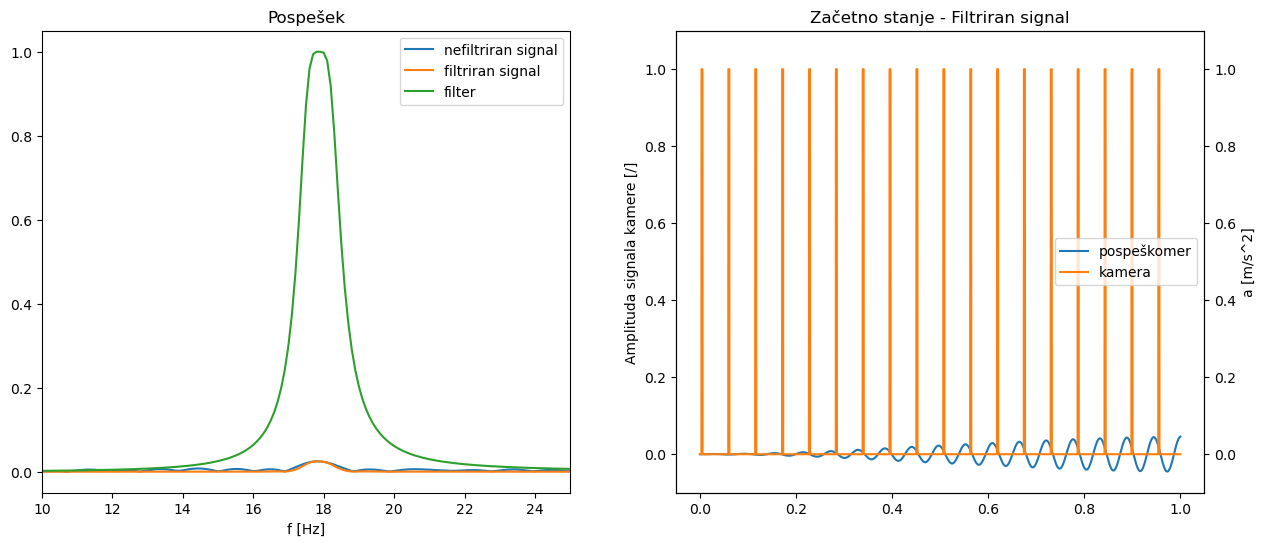

In [7]:
#FILTRIRANJE, ZERRO PADDING
#ustvarimo pasovni filter
freq_band_a = np.array([f-0.5, f+0.5])
b, a = signal.butter(2, freq_band_a, btype='band', fs = f_vz)

#prehod v frekvenčno domeno
A0 = np.fft.rfft(a0, n = 10*25600)/len(a0) #zerro padding
freq = np.fft.rfftfreq(len(t)*10, dt)
w, H = signal.freqz(b, a, len(freq), fs=f_vz)

#Aplicirnaje filtra(množenje v frekvenčni domeni)
A0_filt = A0 * H

#vrnitev v časovno domeno
a0_filt_zerro = np.fft.irfft(A0_filt) * len(a0)

a0_filt = a0_filt_zerro[:25600]


#izris
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(freq, np.abs(A0), label = "nefiltriran signal")
ax[0].plot(freq, np.abs(A0_filt), label = "filtriran signal")
ax[0].plot(freq, np.abs(H), label = "filter")
ax[0].set_title("Pospešek")
ax[0].legend()
ax[0].set_xlim(10,25)
ax[0].set_xlabel("f [Hz]")

ax[1].plot(t, a0_filt, label = "pospeškomer")
ax[1].plot(t, n0_filt, label = "kamera")
ax[1].set_ylabel("Amplituda signala kamere [/]")
ax[1].set_ylim(-0.1,1.1)
ax[1].set_title("Začetno stanje - Filtriran signal")
ax3 = ax[1].twinx()
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel("a [m/s^2]")
ax[1].legend()
plt.show()

**Komentar**: Zaradi dodajanja ničel, amplituda sinusnega signala narašča in ni konstantna, smo pa bolje filtrirali frekvence, saj nimamo več spreminjanja faznega zamika v času. Moramo biti pozorni, da je zaradi dodajanja ničel signal pospeška v času podaljšan, zato se koristen signal nahaja tudi izven 1 sekunde meritve. Pri odčitavanju maksimalnega pospeška moramo upoštevati celoten signal in ne samo prve sekunde.

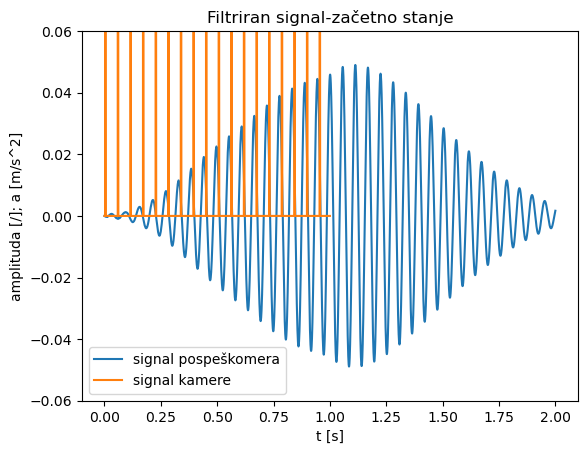

Amplituda pospeška začetnega stanja znaša: a0_max = 0.049 m/s^2


In [8]:
t1 = np.linspace(0,2,2*25600)
plt.plot(t1, a0_filt_zerro[:2*25600], label = "signal pospeškomera")
plt.plot(t, n0_filt, label = "signal kamere")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/]; a [m/s^2]")
plt.title("Filtriran signal-začetno stanje")
plt.ylim(-0.06,0.06)
plt.legend()
plt.show()

#Maksimalni pospešek
a0_max = np.max(a0_filt_zerro)
print(f'Amplituda pospeška začetnega stanja znaša: a0_max = {a0_max:0.3f} m/s^2')

In [9]:
#Shranimo čase zadnjih nekaj makismumov pospeška
indeks_vrhov_a0=sp.signal.find_peaks(a0_filt,[0.03,0.06])[0]
t_vrh_a0 = []
for i in range(0,len(indeks_vrhov_a0)):
    t_vrh_a0.append(t[indeks_vrhov_a0[i]])

#Vzamemo čase pripadajočih pulzov kamere
t_vrh_0_prim =t_vrh_0[-(len(t_vrh_a0)+1):-1]

In [10]:
#primerjamo zadnjih nekaj ponovitev
counter = 0
for i in range(0,len(t_vrh_a0)):
    counter += t_vrh_a0[i] - t_vrh_0_prim[i] 
    #print(ω*(t_vrh_0_prim[i] - t_vrh_a0[i]))
    
#Izraučn povprečnega faznega zamika
delta_t0 = counter/len(t_vrh_a0)
ϕ_a0_povp = ω*delta_t0
ϕ_a0_povp

print(f'Fazni zamik začetnega stanja znaša: ϕ = {ϕ_a0_povp:0.3f} rad')
print(f'Amplituda pospeška začetnega stanja znaša: a0_max = {a0_max:0.3f} m/s^2')

Fazni zamik začetnega stanja znaša: ϕ = 5.206 rad
Amplituda pospeška začetnega stanja znaša: a0_max = 0.049 m/s^2


## Testno stanje

### Uvoz podatkov

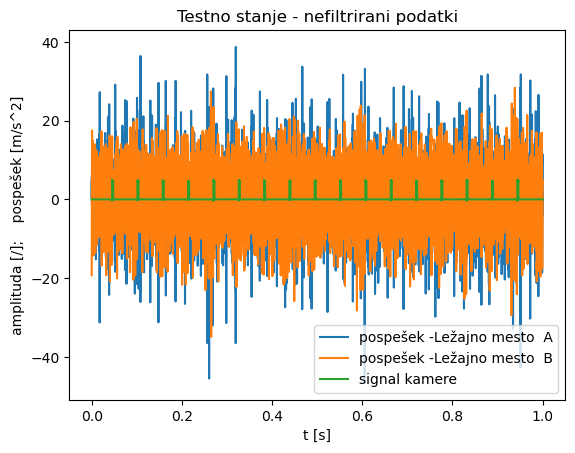

In [11]:
file1 = np.load("LV balansiranje - testno_stanje.npy",allow_pickle=True, fix_imports=True)
file1 = file1[()]["data"]

a1 = file1[:,0]
b1 = file1[:,1]
n1 = file1[:,2]

plt.plot(t,a1, label = "pospešek -Ležajno mesto  A")
plt.plot(t,b1, label = "pospešek -Ležajno mesto  B")
plt.plot(t,n1, label = "signal kamere")
plt.title("Testno stanje - nefiltrirani podatki")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/];    pospešek [m/s^2]")
plt.legend()
plt.show()

### Filtriranje signala kamere/sonde

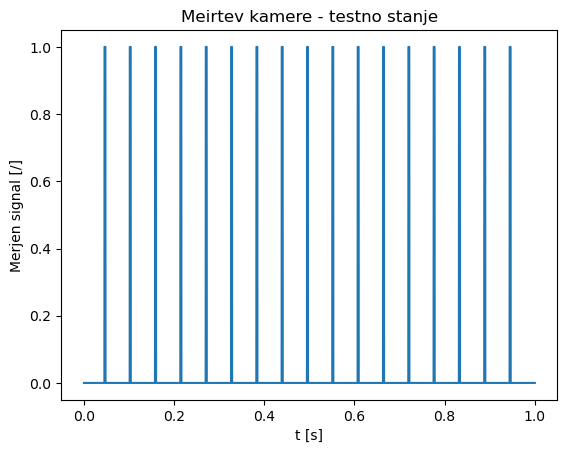

In [12]:
#filtriramo signal kamere
n1_filt = np.array([])
for i in n1:
    if i > 3:
        n1_filt = np.append(n1_filt, 1)
    else:
        n1_filt = np.append(n1_filt, 0)

plt.plot(t, n1_filt)
plt.title("Meirtev kamere - testno stanje")
plt.xlabel("t [s]")
plt.ylabel("Merjen signal [/]")
plt.show()
plt.show()

In [13]:
#odvajamo, da dobimo točke kjer se zgodi sprememba
odvod_1 = np.gradient(n1_filt, dt)

#Shranimo čase, kjer kamera zabeleži referenčno točko
indeks_vrhov_1=sp.signal.find_peaks(odvod_1)[0]
t_vrh_1 = []
for i in range(0,len(indeks_vrhov_1)):
    t_vrh_1.append(t[indeks_vrhov_1[i]+1]) #pri i-tem indeksu je vrednost reelksivnosti še 0

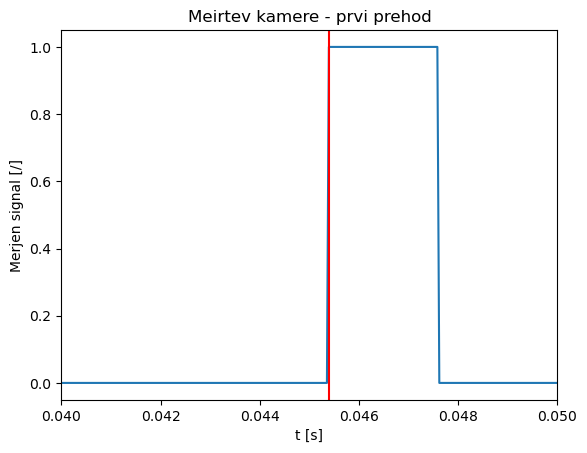

In [14]:
plt.plot(t,n1_filt, "-")
plt.axvline(t_vrh_1[0], color='r')
plt.title("Meirtev kamere - prvi prehod")
plt.xlabel("t [s]")
plt.ylabel("Merjen signal [/]")
plt.xlim(0.04,0.05)
plt.show()

### filtriranje pospeška

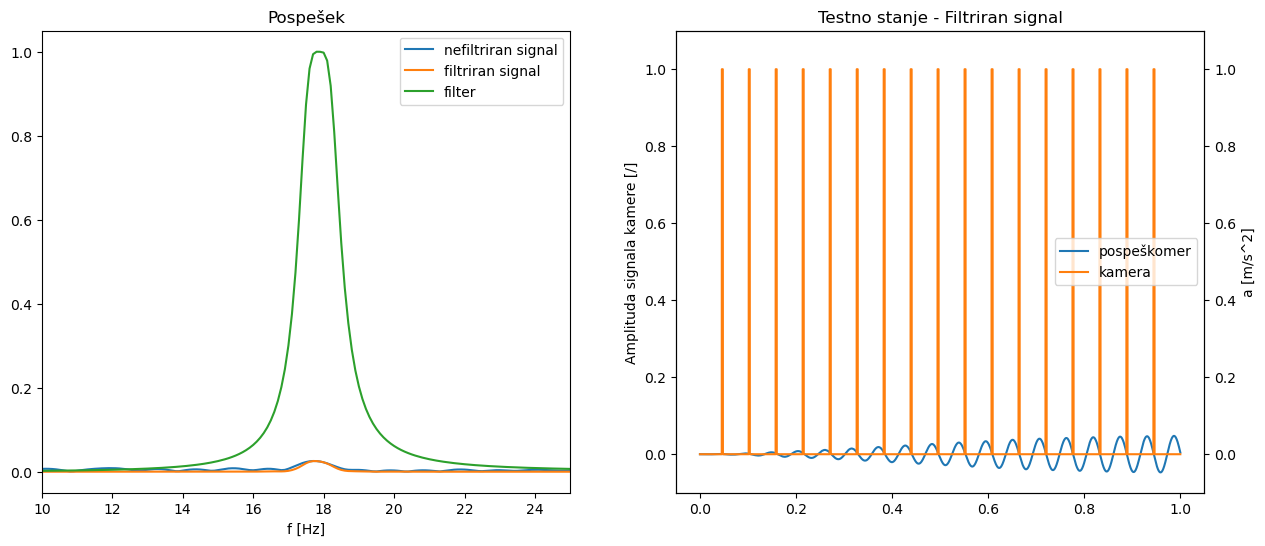

In [15]:
#prehod v frekvenčno domeno
A1 = np.fft.rfft(a1, n = 10*25600)/len(a1) #zerro padding

#Aplicirnaje filtra(množenje v frekvenčni domeni)
A1_filt = A1 * H

#vrnitev v časovno domeno
a1_filt_zerro = np.fft.irfft(A1_filt) * len(a1)

a1_filt = a1_filt_zerro[:25600]


#izris
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(freq, np.abs(A1), label = "nefiltriran signal")
ax[0].plot(freq, np.abs(A1_filt), label = "filtriran signal")
ax[0].plot(freq, np.abs(H), label = "filter")
ax[0].set_title("Pospešek")
ax[0].legend()
ax[0].set_xlim(10,25)
ax[0].set_xlabel("f [Hz]")

ax[1].plot(t, a1_filt, label = "pospeškomer")
ax[1].plot(t, n1_filt, label = "kamera")
ax[1].set_ylabel("Amplituda signala kamere [/]")
ax[1].set_ylim(-0.1,1.1)
ax[1].set_title("Testno stanje - Filtriran signal")
ax3 = ax[1].twinx()
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel("a [m/s^2]")
ax[1].legend()
plt.show()

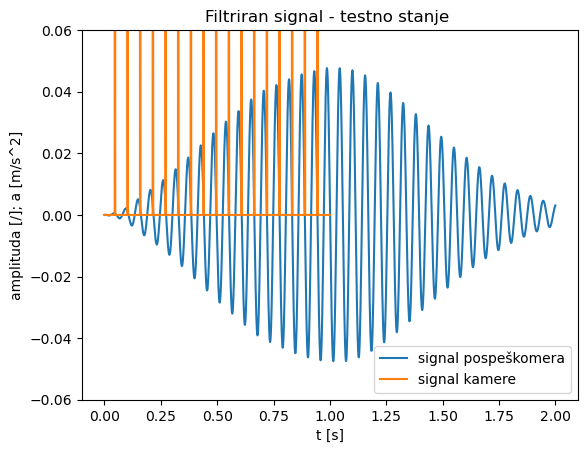

In [16]:
plt.plot(t1, a1_filt_zerro[:2*25600], label = "signal pospeškomera")
plt.plot(t, n1_filt, label = "signal kamere")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/]; a [m/s^2]")
plt.title("Filtriran signal - testno stanje ")
plt.ylim(-0.06,0.06)
plt.legend()
plt.show()

#Maksimalni pospešek
a1_max = np.max(a1_filt_zerro)

In [17]:
#Shranimo čase zadnjih nekaj makismumov pospeška
indeks_vrhov_a1=sp.signal.find_peaks(a1_filt,[0.03,0.06])[0]
t_vrh_a1 = []
for i in range(0,len(indeks_vrhov_a1)):
    t_vrh_a1.append(t[indeks_vrhov_a1[i]])
t_vrh_a1 = t_vrh_a1[:-1] #OPOMBA: iz zgornjega grafa vidimo, da zadnji vrh pospeška nima pripadajočega referenčnega časa

#Vzamemo čase pripadajočih pulzov kamere
t_vrh_1_prim =t_vrh_1[-(len(t_vrh_a1)+1):-1]

In [18]:
#primerjamo izbrane ponovitve
counter = 0
for i in range(0,len(t_vrh_a1)):
    counter += t_vrh_a1[i] - t_vrh_1_prim[i] 
    
    
#Izraučn povprečnega faznega zamika 
delta_t1 = counter/len(t_vrh_a1)
ϕ_a1_povp = ω*delta_t1
ϕ_a1_povp

#Maksimalni pospešek
a1_max = np.max(a1_filt_zerro)

print(f'Fazni zamik testenga stanja znaša: ϕ = {ϕ_a1_povp:0.3f} rad')
print(f'Amplituda pospeška testnega stanja znaša: a1_max = {a1_max:0.3f} m/s^2')

Fazni zamik testenga stanja znaša: ϕ = 4.895 rad
Amplituda pospeška testnega stanja znaša: a1_max = 0.048 m/s^2


## IZRAČUNI

In [20]:
m_test = 2.8 #g

#balansiranje v kompleksni ravnini
v0 = a0_max*np.cos(ϕ_a0_povp) + 1j *a0_max*np.sin(ϕ_a0_povp)
v1 = a1_max*np.cos(ϕ_a1_povp) + 1j *a1_max*np.sin(ϕ_a1_povp)
vt = v1-v0
Q = -v0/vt


    
print(f'v0 = {v0.real:.4f} {v0.imag:+.4f}j')
print(f'v1 = {v1.real:.4f} {v1.imag:+.4f}j')
print(f'vt = {vt.real:.4f} {vt.imag:+.4f}j')
print(f'Q = {Q.real:.4f} {Q.imag:+.4f}j\n')

m_a2 = abs(Q)*m_test

if Q.real >= 0:
    α_a2 = np.arctan(Q.imag/Q.real)
else:
    α_a2 = np.arctan(Q.imag/Q.real)+np.pi
print(f'Masa korekcijske uteži = {m_a2:0.2f} g')
print(f'Položaj korekcijske mase = {α_a2:0.2f} rad = {α_a2*180/np.pi:0.2f}°')

v0 = 0.0232 -0.0432j
v1 = 0.0087 -0.0469j
vt = -0.0145 -0.0037j
Q = 0.7911 -3.1695j

Masa korekcijske uteži = 9.15 g
Položaj korekcijske mase = -1.33 rad = -75.99°


# Ležajno mesto B

## filtriranje pospeška - začetno stanje

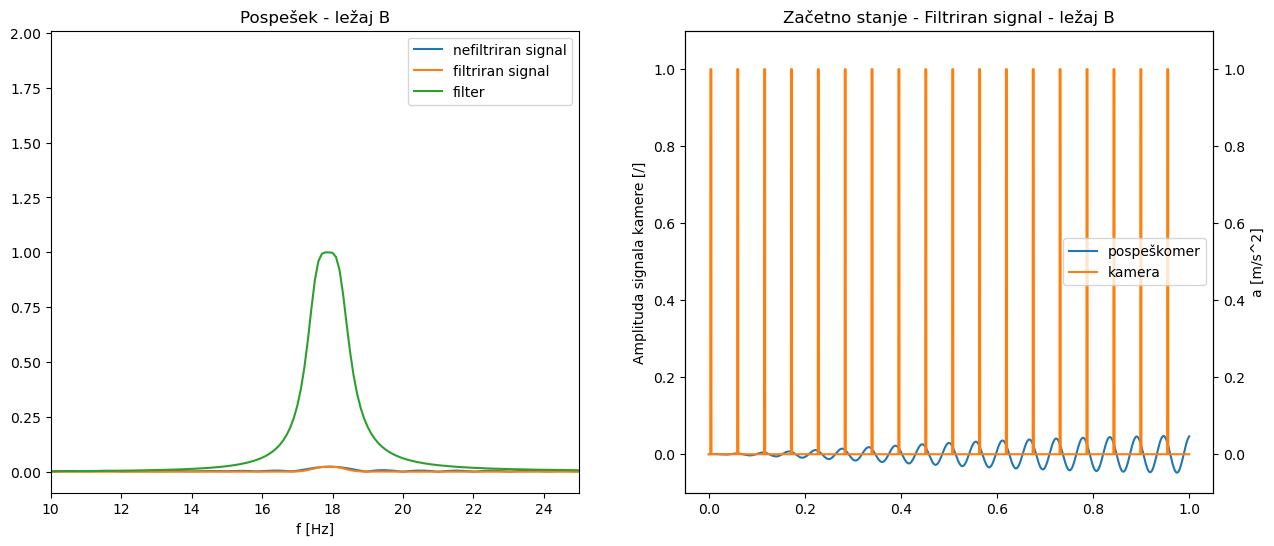

In [21]:
#FILTRIRANJE, ZERRO PADDINg

#prehod v frekvenčno domeno
B0 = np.fft.rfft(b0, n = 10*25600)/len(b0) #zerro padding

#Aplicirnaje filtra(množenje v frekvenčni domeni)
B0_filt = B0 * H

#vrnitev v časovno domeno
b0_filt_zerro = np.fft.irfft(B0_filt) * len(b0)

b0_filt = b0_filt_zerro[:25600]


#izris
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(freq, np.abs(B0), label = "nefiltriran signal")
ax[0].plot(freq, np.abs(B0_filt), label = "filtriran signal")
ax[0].plot(freq, np.abs(H), label = "filter")
ax[0].set_title("Pospešek - ležaj B")
ax[0].legend()
ax[0].set_xlim(10,25)
ax[0].set_xlabel("f [Hz]")

ax[1].plot(t, b0_filt, label = "pospeškomer")
ax[1].plot(t, n0_filt, label = "kamera")
ax[1].set_ylabel("Amplituda signala kamere [/]")
ax[1].set_ylim(-0.1,1.1)
ax[1].set_title("Začetno stanje - Filtriran signal - ležaj B")
ax3 = ax[1].twinx()
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel("a [m/s^2]")
ax[1].legend()
plt.show()

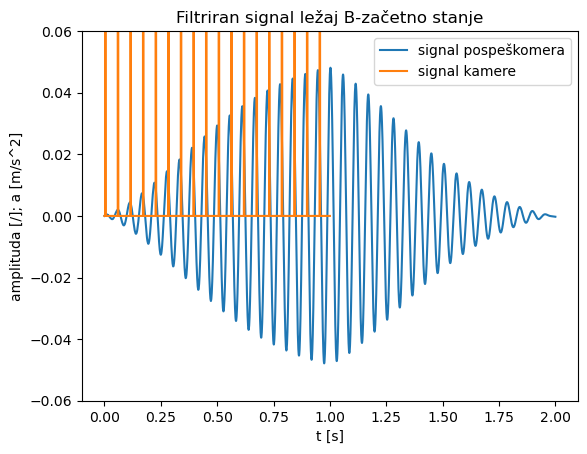

Amplituda pospeška začetnega stanja (ležaj B) znaša: b0_max = 0.048 m/s^2


In [22]:
plt.plot(t1, b0_filt_zerro[:2*25600], label = "signal pospeškomera")
plt.plot(t, n0_filt, label = "signal kamere")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/]; a [m/s^2]")
plt.title("Filtriran signal ležaj B-začetno stanje")
plt.ylim(-0.06,0.06)
plt.legend()
plt.show()

#Maksimalni pospešek
b0_max = np.max(b0_filt_zerro)
print(f'Amplituda pospeška začetnega stanja (ležaj B) znaša: b0_max = {b0_max:0.3f} m/s^2')

In [23]:
#Shranimo čase zadnjih nekaj makismumov pospeška
indeks_vrhov_b0=sp.signal.find_peaks(b0_filt,[0.03,0.06])[0]
t_vrh_b0 = []
for i in range(0,len(indeks_vrhov_b0)):
    t_vrh_b0.append(t[indeks_vrhov_b0[i]])

#Vzamemo čase pripadajočih pulzov kamere
t_vrh_0_prim_B =t_vrh_0[-(len(t_vrh_b0)+1):-1]

In [24]:
#primerjamo zadnjih nekaj ponovitev
counter = 0
for i in range(0,len(t_vrh_b0)):
    counter += t_vrh_b0[i] - t_vrh_0_prim_B[i]
    #print(ω*(t_vrh_b0[i]-t_vrh_0_prim_B[i]))
    
#Izraučn povprečnega faznega zamika
delta_t0_B = counter/len(t_vrh_b0)
ϕ_b0_povp = ω*delta_t0_B
ϕ_b0_povp
print(f'LEŽAJNO MESTO B:\n')
print(f'Fazni zamik začetnega stanja znaša: ϕ = {ϕ_b0_povp:0.3f} rad')
print(f'Amplituda pospeška začetnega stanja znaša: b0_max = {b0_max:0.3f} m/s^2')

LEŽAJNO MESTO B:

Fazni zamik začetnega stanja znaša: ϕ = 5.489 rad
Amplituda pospeška začetnega stanja znaša: b0_max = 0.048 m/s^2


## filtriranje pospeška - testno stanje

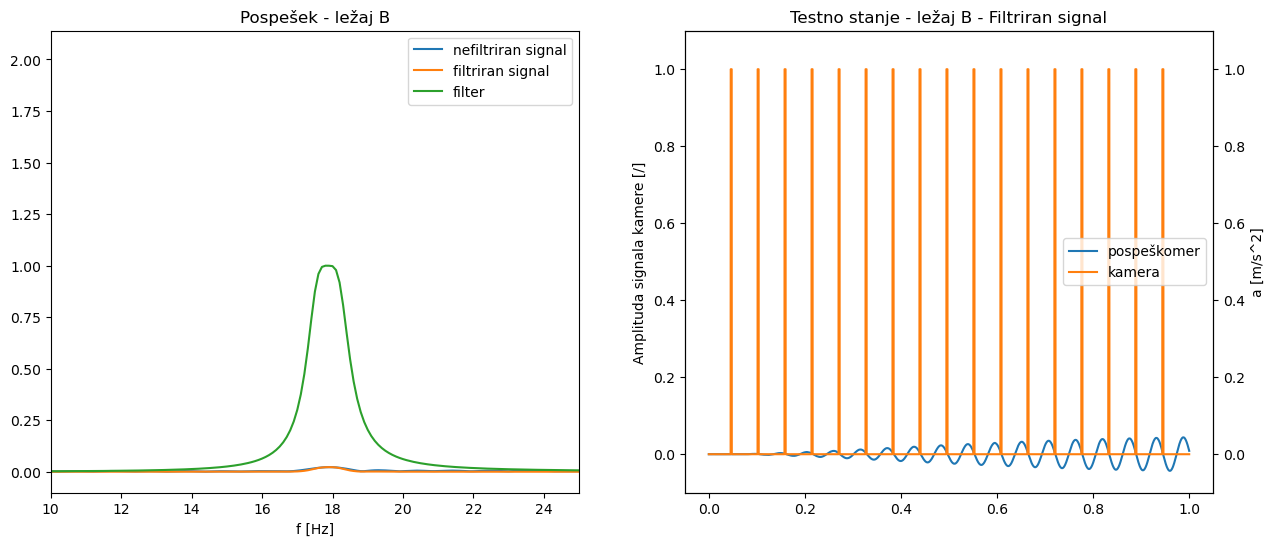

In [25]:
#prehod v frekvenčno domeno
B1 = np.fft.rfft(b1, n = 10*25600)/len(b1) #zerro padding

#Aplicirnaje filtra(množenje v frekvenčni domeni)
B1_filt = B1 * H

#vrnitev v časovno domeno
b1_filt_zerro = np.fft.irfft(B1_filt) * len(b1)

b1_filt = b1_filt_zerro[:25600]


#izris
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(freq, np.abs(B1), label = "nefiltriran signal")
ax[0].plot(freq, np.abs(B1_filt), label = "filtriran signal")
ax[0].plot(freq, np.abs(H), label = "filter")
ax[0].set_title("Pospešek - ležaj B")
ax[0].legend()
ax[0].set_xlim(10,25)
ax[0].set_xlabel("f [Hz]")

ax[1].plot(t, b1_filt, label = "pospeškomer")
ax[1].plot(t, n1_filt, label = "kamera")
ax[1].set_ylabel("Amplituda signala kamere [/]")
ax[1].set_ylim(-0.1,1.1)
ax[1].set_title("Testno stanje - ležaj B - Filtriran signal")
ax3 = ax[1].twinx()
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel("a [m/s^2]")
ax[1].legend()
plt.show()

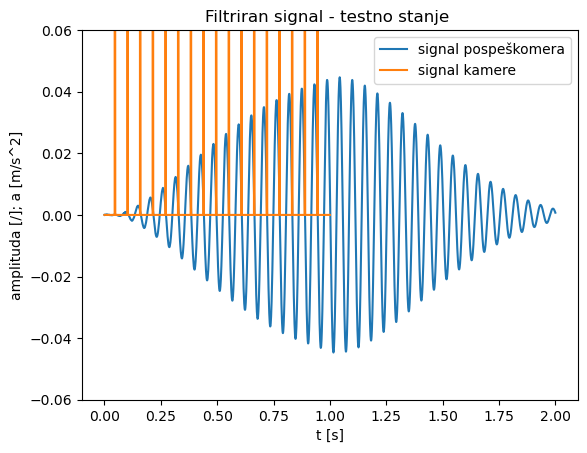

In [26]:
plt.plot(t1, b1_filt_zerro[:2*25600], label = "signal pospeškomera")
plt.plot(t, n1_filt, label = "signal kamere")
plt.xlabel("t [s]")
plt.ylabel("amplituda [/]; a [m/s^2]")
plt.title("Filtriran signal - testno stanje ")
plt.ylim(-0.06,0.06)
plt.legend()
plt.show()

#Maksimalni pospešek
b1_max = np.max(b1_filt_zerro)

In [27]:
#Shranimo čase zadnjih nekaj makismumov pospeška
indeks_vrhov_b1=sp.signal.find_peaks(b1_filt,[0.03,0.06])[0]
t_vrh_b1 = []
for i in range(0,len(indeks_vrhov_b1)):
    t_vrh_b1.append(t[indeks_vrhov_b1[i]])
t_vrh_b1 = t_vrh_b1[:-1] #OPOMBA: iz zgornjega grafa vidimo, da zadnji vrh pospeška nima pripadajočega referenčnega časa

#Vzamemo čase pripadajočih pulzov kamere
t_vrh_1_prim_B =t_vrh_1[-(len(t_vrh_b1)+1):-1]

In [28]:
#primerjamo izbrane ponovitve
counter = 0
for i in range(0,len(t_vrh_b1)):
    counter += t_vrh_b1[i]-t_vrh_1_prim_B[i]
    #print(ω*(t_vrh_b1[i]-t_vrh_1_prim_B[i]t_vrh_b1[i]))
    
#Izraučn povprečnega faznega zamika 
delta_t1_B = counter/len(t_vrh_b1)
ϕ_b1_povp = ω*delta_t1_B
ϕ_b1_povp

#Maksimalni pospešek
b1_max = np.max(b1_filt_zerro)

print(f'LEŽAJNO MESTO B:\n')
print(f'Fazni zamik testenga stanja znaša: ϕ = {ϕ_b1_povp:0.3f} rad')
print(f'Amplituda pospeška testnega stanja znaša: b1_max = {b1_max:0.3f} m/s^2')

LEŽAJNO MESTO B:

Fazni zamik testenga stanja znaša: ϕ = 4.958 rad
Amplituda pospeška testnega stanja znaša: b1_max = 0.045 m/s^2


## Izračuni

In [29]:
#balansiranje v kompleksni ravnini
v0_B = b0_max*np.cos(ϕ_b0_povp) + 1j *b0_max*np.sin(ϕ_b0_povp)
v1_B = b1_max*np.cos(ϕ_b1_povp) + 1j *b1_max*np.sin(ϕ_b1_povp)
vt_B = v1_B-v0_B
Q_B = -v0_B/vt_B


    
print(f'v0 = {v0_B.real:.4f} {v0_B.imag:+.4f}j')
print(f'v1 = {v1_B.real:.4f} {v1_B.imag:+.4f}j')
print(f'vt = {vt_B.real:.4f} {vt_B.imag:+.4f}j')
print(f'Q = {Q_B.real:.4f} {Q_B.imag:+.4f}j\n')

m_B = abs(Q_B)*m_test

if Q_B.real >= 0:
    α_B = np.arctan(Q_B.imag/Q_B.real)
else:
    α_B = np.arctan(Q_B.imag/Q_B.real)+np.pi
print(f'Masa korekcijske uteži = {m_B:0.2f} g')
print(f'Položaj korekcijske mase = {α_B:0.2f} rad = {α_B*180/np.pi:0.2f}°')

v0 = 0.0337 -0.0343j
v1 = 0.0109 -0.0433j
vt = -0.0229 -0.0090j
Q = 0.7637 -1.8033j

Masa korekcijske uteži = 5.48 g
Položaj korekcijske mase = -1.17 rad = -67.05°
